# Py: Explainable Models with SHAP
by Jonathan Tan. Originally published in Actuaries Digital as [Explainable ML: A peek into the black box through SHAP](https://www.actuaries.digital/2021/02/05/explainable-ml-a-peek-into-the-black-box-through-shap/).

With data becoming more widely available, there are more and more companies using powerful machine learning models to outperform their competitors. The insurance industry is no exception, and a good model can help the insurer gain a competitive advantage in areas such as(but not limited to):

- Pricing accurately to reduce the risk of adverse selection
- Reserving models that allow for optimal use of assets
- Customer segmentation for campaigns to maximize cost and benefit
- NLP models for customer sentiment analysis
- Fraud detection for claims
- Underwriting automation for life insurance
- Customer service automation

However, the biggest downside of using these powerful models is **losing the ability to easily interpret the results and the driving factors of the predicted outcomes**, hence the term "black box models". While the police department in the [Minority Report](https://en.wikipedia.org/wiki/Minority_Report_(film)) certainly did not think twice about understanding their predictions before launching a full-on manhunt after their own unit head (played by Tom Cruise), it is highly unlikely that upper management and other stakeholders will react in the same fashion on the first instance of looking at a set of model results.

While an actuary may not necessarily be involved in all the areas listed above, they would most probably be exposed to at least one of them in their day job.  GLMs and GAMs offer this transparency and unambiguity of model results, but limits the model choice, which may sometimes cause an issue when the underlying interactions are more complex and require a more complicated black box model to accommodate.

Thankfully, there are some tools and techniques (called explanation models) available that aims to explain the driving factors of a prediction from a powerful black box model, with some example use cases (depending on the model):

- Drivers of unexpectedly low/high price of a policy to external stakeholders
- Providing evidence to regulators that underwriting decisions are data driven
- Providing the driving factors to why a claim was deemed to be fraudulent
- Reasons a particular customer profile is preferable for a targeted campaign
- Checking and debugging the model to make sure that the driving factors of a certain prediction are in line with expectations

This article will provide a gentle introduction to SHAP, one of the explanation models mentioned above. It was introduced as a unified approach to model interpretation and is currently the only explanation model that relies on solid and well understood economic theory instead of heuristic methods, which other popular methods (like LIME) are based on.

While this article will not provide a universal solution for the actuary to start using these black box models imprudently, it aims to encourage the exploration of these powerful black box models and give the reader a starting point for its interpretation.

## Run this from the browser

Although this article will make use of the Python implementation, there is also a R wrapper for the SHAP package called [shapper](https://github.com/ModelOriented/shapper), and ml3, which works with the [DALEX](https://mlr-org.com/docs/mlr3-loves-dalex/) framework. For more information on how to get started with DALEX, check out [Jacky Poon's top 10 R packages for data analysis](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/topten-r-packages/).

The python code shown this snippet can be run from the browser through this [link](https://mybinder.org/v2/gh/jtsw1990/shap_article/HEAD).

Note that some loading time is to be expected, particularly when performing grid search and cross-validation for the machine learning models. However, the binder does not require the reader to download the dataset, or any other dependencies to run the models. Furthermore, the reader is encouraged to play around with the code and look at how SHAP explains the different predictions, as well as explore the other graphs that the SHAP package has to offer.

## Tools and Packages

The example uses [Python3](https://www.python.org/downloads/release/python-379/) and the main packages that we will be using are listed below:

- [Shap](https://pypi.org/project/shap/) for model validation
- [Matplotlib](https://pypi.org/project/matplotlib/) for visualisation as SHAP graphs uses it as a backend
- [Pandas](https://pypi.org/project/pandas/) and [Numpy](https://pypi.org/project/numpy/) for general data manipulation
- [Sci-kit learn's](https://pypi.org/project/scikit-learn/) pipeline framework and machine learning algorithms

Note that the sklearn pipeline is the main backbone of the process here out of convenience but any other workflow/ pre-processing framework would work just as well.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import warnings
from IPython.display import Image
from IPython.core.display import HTML 

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor

warnings.filterwarnings('ignore')
plt.ioff()

## Importing, Preprocessing, Modelling

The dataset used in this article includes some policyholder information as follows: 

- **age**: Policyholder age (_integer_)
- **sex**: Gender of the policyholder (_string_)
- **bmi**: Body mass index (_float_)
- **children**: Number of children/ dependents of policyholder (_integer_)
- **smoker**: Smoking state of policyholder (_string_)
- **region**: Residential area of the policyholder in the US (_string_)

As well as a **claims cost** response column. The data can be downloaded from the Github repository [here](https://github.com/sharmaroshan/Insurance-Claim-Prediction).

Note that although all the usual steps in the modelling process are involved here, this article will mainly focus on using the SHAP package and interpreting the model predictions. With that in mind, the rest of this section will not be covered in detail, but includes:
- Importing the data
- Splitting the dataset into training and testing sets
- Creating a "preprocessor" step to one-hot-encode categorical features
- Building a sklearn pipeline with the pre-processing step and a GBM Regressor model
- Performing grid search and cross-validation for the GBM model to get the "best" set of hyperparameters
- 2 very brief/high-level checks to ensure that:
    - Model predictions approximate the actual values
    - The model has not overfitted on the training set

#### Importing

In [2]:
# Import data from GitHub repository
df = pd.read_csv("https://raw.githubusercontent.com/sharmaroshan/Insurance-Claim-Prediction/master/insurance.csv")

# Get column names for independent and response variables
rating_factors_col = list(df.columns[:-1])
claims_col = df.columns[-1]

In [3]:
df.head(3)

age     sex    bmi  children smoker     region     charges
0   19  female  27.90         0    yes  southwest  16884.9240
1   18    male  33.77         1     no  southeast   1725.5523
2   28    male  33.00         3     no  southeast   4449.4620

In [4]:
# Splitting up the categorical columns and numerical columns
# This is to differentiate the pre-processing functions applied later in the pipeline

num_features = list(df[rating_factors_col].select_dtypes(include=["int64", "float64"]).columns)
cat_features = [col for col in rating_factors_col if col not in num_features]

#### Preprocessing

In [5]:
# Split our dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
            df[rating_factors_col],
            df[claims_col],
            test_size=0.2,
            random_state=123
        )

In [6]:
# Create a preprocessor step
# This ignores numerical columns but applies OHE to categorical features

preprocessor = ColumnTransformer(
    transformers = [
        ("numerical", "passthrough", num_features),
        ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"), cat_features)
    ]
)

In [7]:
# Some wrangling done to get OHE feature names
# Note that preprocess.get_feature_names() can be used as well but by default produces x prefix which I did not want

ohe_categories = preprocessor.fit(X_train).named_transformers_["categorical"].categories_
ohe_categories_concat = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]
rating_factors_encoded = num_features + ohe_categories_concat

In [8]:
# Create a dictionary of hyperparameters to be optimised
# Create a sklearn Pipeline object which takes in the preprocessor step as well as a GBM object

param_grid = {
    "model__learning_rate": [0.01, 0.1],
    "model__max_depth": [2, 3, 4],
    "model__min_samples_leaf": [1, 3, 5],
    "model__min_samples_split": [2, 4],
    "model__n_estimators": [100, 200]
}

gbm_model = Pipeline([("preprocessor", preprocessor), ("model", GradientBoostingRegressor())])

#### Modelling: Gradient Boosted Machine

In [9]:
# Instantiate a gridsearch-cross validation object
# This takes in our previously created gbm pipeline and grid of hyperparameters to be tested
# Using a standard 5-part CV split with MSE as a score as we are doing a regression exercise

gs = GridSearchCV(
    gbm_model, 
    param_grid=param_grid, 
    n_jobs=-1, 
    cv=5, 
    scoring="neg_mean_squared_error",
    verbose=0
)

In [10]:
# Run the gridsearch, set the hyperparameters to the set which gave us the lowest MSE
# Fit the optimised model on our training data set and get test set predictions

_gs = gs.fit(X_train, y_train)

gbm_model.set_params(**gs.best_params_)
gbm_model.fit(X_train, y_train)
gbm_pred = gbm_model.predict(X_test)

#### Reasonableness checks

In [11]:
# Function created to create a multiple bar chart comparing actual vs predicted claims by deciles

def plot_avepp(df, expected, actual):
    avepp = df.assign(
        model_bands=pd.qcut(df[expected], 10, labels=np.arange(10) + 1),
    ).groupby("model_bands")[[expected, actual]].agg("sum").reset_index()
    n = avepp["model_bands"].max()
    width = 0.35
    ax = plt.subplot(111)
    pred_fig = ax.bar(np.arange(n) + width, avepp[expected], width)
    actual_fig = ax.bar(np.arange(n), avepp[actual], width)
    ax.set_title("AvE Decile Plot")
    ax.set_xticks(np.arange(n) + width / 2)
    ax.set_xticklabels(np.arange(n) + 1)
    ax.legend((pred_fig[0], actual_fig[0]), ("Pred", "Actual"))
    plt.show()

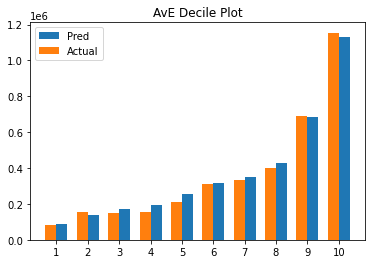

In [12]:
test_results = pd.concat(
    [
        X_test.reset_index(),
        pd.DataFrame(gbm_pred, columns=["predicted"]),
        pd.DataFrame(y_test).reset_index(),
    ], 
    axis=1
).drop("index", axis=1)

plot_avepp(test_results, "predicted", "charges")

In [28]:
# Checking RMSE for training and testing sets
# An indication of overfitting would be a very low training RMSE with a high testing RMSE

print("Overfitting Check")
print("Testing RMSE: {}".format(mean_squared_error(y_test, gbm_pred, squared=False)))
print("Training RMSE: {}".format(mean_squared_error(y_train, gbm_model.predict(X_train), squared=False)))

Overfitting Check
Testing RMSE: 3720.6925277868554
Training RMSE: 4309.477401843349


## Model Validation

#### What is SHAP?

SHAP stands for SHapley Additive exPlanations and uses a game theory approach (Shapley Values) applied to machine learning to "fairly allocate contributions" to the model features for a given output. The underlying process of getting SHAP values for a particular feature $f$ out of the set $F$ can be summarized as follows:

- Get the [Power Set](https://en.wikipedia.org/wiki/Power_set) of $F$, which  contains $2^{F}$ combinations of features
- Run the model for all possible combinations, treating features outside of the subset as missing
- Record the marginal contributions to the model output for $f$
- Calculate a weighted sum of $f$'s marginal contributions to get the SHAP value of feature $f$ for a given output. Or in other words, $f$'s expected contribution to the model output

Just from looking at the steps mentioned above, we can infer that this approach would have 2 major issues to solve:
1. Statistical models typically are not able to handle missing values
2. $2^{F}$ is exponential complexity $O(2^{N})$, which is not feasible in most cases

Thankfully, there is a user-friendly API for us to define what "missing" means by creating background dataset that imputes the missing values while running our models. As for (2), SHAP values are generally approximated with sampling subsets of $2^{F}$. However, in the case of tree-based models and deep neural networks, there are elegant solutions implemented such that we can get exact solutions that run in polynomial $O(N^{2})$ time!

While the article will not delve into the details on how the SHAP algorithm handles these issues, there are various resources in the appendix with more detail.

#### SHAP package in Python

The SHAP python framework provides a variety of visualisations for model validation that can be found [here](https://shap.readthedocs.io/en/latest/api.html). However, for the purposes of this article, the focus will be on the Waterfall, Force and Dependency plots to interpret model predictions.

We will also look at the results in the context of a particular observation with index=30.

In [14]:
idx = 30
feature = "bmi"

shap_df = pd.DataFrame(gbm_model.named_steps["preprocessor"].transform(X_train), columns=rating_factors_encoded)

Like the LIME package, SHAP works with explainer objects to calculate the results, and provides us with 3 main explainer categories:

- shap.TreeExplainer
- shap.DeepExplainer
- shap.KernelExplainer

The first 2 are model specific algorithms, which makes use of the model architecture for optimizations to compute exact SHAP values as mentioned above. The KernelExplainer on the other hand, is a model agnostic algorithm uses sampling to approximate SHAP values. Since a GBM regressor is the model of choice, the TreeExplainer object is used for explanations in the following sections.

In [15]:
gbm_explainer = shap.TreeExplainer(gbm_model.named_steps["model"])
gbm_shap_values = gbm_explainer(shap_df)

# This line below is a quick workaround to get pass an assert condition in the SHAP 
# plots.waterfall source code. Can be ignored
gbm_shap_values.base_values = gbm_shap_values.base_values[:, 0]

#### Waterfall Plots (Local)

The SHAP waterfall plots aims to explain how individual claim predictions are derived.

1. The Y-axis encodes features, with the values observed for idx=30
2. The X-axis encodes the range of our response (claims costs) in dollars
3. Note that $E[f(X)]=\$13,189.258$ is the result from the null model, or the global average claims cost from our dataset
4. Also note that $f(x)=\$14,959.311$ is the model prediction for values observed in (1)

The plot below shows that this policyholder’s expected claims cost is ~13% higher than the average, and both the gender and region did not contribute materially to this outcome. While the higher-than-average BMI did contribute to ~$1.3k more to the costs, this was mostly offset by the fact that she had no children.

The 2 main drivers mostly offset each other as well, but the fact that she is aged outweighed the effect of being a non-smoker by ~$1.4k, which makes up the bulk of the net increase from the average.

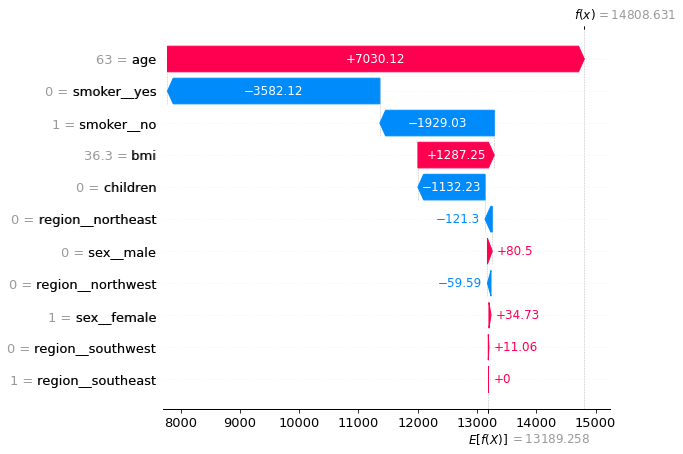

In [16]:
shap.plots.waterfall(gbm_shap_values[idx], max_display=14, show=False)
plt.show()

#### Force plots ("Global")

The force plots in the SHAP package can output both local and "global" interpretation graphs. While it does not provide a global explanation in the form of an equation like in our GLMs, it does give us a model-level view of the results to work with. This is done by stacking and sorting all the SHAP values for all predictions into 1 plot as shown below. 

While both axes can be customized from the combo box, by default, the Y-axis shows the output value of the model, while the X-axis plots all the samples in the dataset sorted by similarity (sorting it by output value is easier to read). Hovering over an area of the graph, provides a quick summary of the significant rating factors that are driving the modelled costs up (in red) or down (in blue). 

At a high level the diagram shows that the model has put a lot of emphasis on the state of smoking and age, which is in line with high BMIs have an interaction effect with smoking, accounting for many of the higher claim predictions.

In [18]:
shap.initjs()
shap.force_plot(gbm_explainer.expected_value[0], gbm_shap_values.values, shap_df)

#### SHAP Dependency plots ("Global")

The SHAP dependency plot is a very simple graph that shows how the SHAP contributions differ for different values of the feature (BMI in this case). This is like a Partial Dependency Plot (PDP), which visualizes the marginal effect of a feature towards the model outcome by plotting out the average model predictions against different values of that feature. The SHAP dependency plots do not average the outcomes and show the variances on the y-axis. Here, there is a clear interaction effect between BMI values and the smoking state of the policyholder.

The pink data points (non-smokers) show a more gradual slope for BMI contributions in contrast to the blue points (smokers), where the SHAP contributions jump significantly at the BMI=~30 point, which is in line with what we could guess from the previous force plot output above.

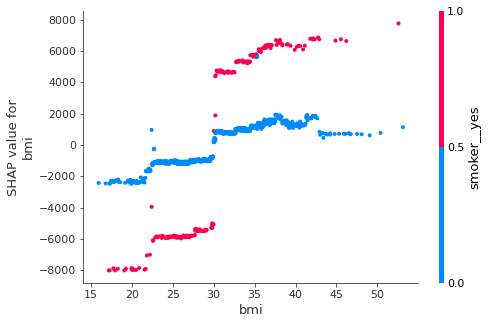

In [19]:
shap.dependence_plot(feature, gbm_shap_values.values, shap_df)

## SHAP vs LIME?

It makes sense to compare the advantages and disadvantages of SHAP to another popular framework like LIME, which also utilizes the idea of an explanation model for local interpretation using some form of linear approximation. Some of the key advantages and disadvantages are:

**Advantages**:
- SHAP provides a complete explanation between the global average and the model output for a particular explanation, whereas LIME's model may not, depending on the fit of the localized linear regression.
- SHAP has the backing of a long-standing and well understood economic theory which guarantees that predictions are fairly distributed among the features whereas LIME does not guarantee this.
- SHAP results provide an (arguably) easy to read global and local view of the model predictions, whereas LIME only offers local interpretations.

**Disadvantages**:
- Only approximate SHAP values are feasible most of the time, the power set of models to compute exact solutions are very computationally expensive. Just imagine computing $2^{20}$ models on a small-sized dataset.
- SHAP does not generate sparse local explanations like LIME does (Models where only a small fraction of features are non-zero), which can be argued to be easier for people to understand and more actionable. The absence of any regularization is the reason SHAP is able to provide a complete explanation (Shapely values) of an observation.
- SHAP values can easily be misinterpreted. By removing the feature for a particular observation, we do not get an outcome of the prediction less the SHAP value of that feature.  This also means that SHAP values cannot make predictions for changes in the input whereas results from LIME allows statements like: "_If this policyholder's BMI increased by 1, the modelled claims cost is expected to increase by ~$500._"

## Afterward

As data becomes increasingly available and insurance products continue to get more complex, the use of more robust models to handles these interactions will be inevitable for many prediction tasks across the whole insurance value chain, not just for claims modelling and fraud detection.

Validation frameworks like SHAP and LIME seem to be a big step in the direction of model-agnostic-additive explanations. While the article provides a gentle and practical introduction to the idea and implementation behind SHAP, note that the theory and mathematics are a little more involved. For those who are interested in deep diving into the details, there are a few links below for further explanation. Andrew Ngai has also previously written an [analytics snippet on SHAP](https://www.actuaries.digital/2019/06/18/analytics-snippet-feature-importance-and-the-shap-approach-to-machine-learning-models/), from the perspective of feature importances using a housing prices data set, which the reader is recommended to check out as it covers some of the other visualisations available in the SHAP package.


- [A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874)
- [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)
- [SHAP framework Github Repository](https://github.com/slundberg/shap)